# SystemAnalysis object-oriented API


This juypter notebook is intended to the RdTools analysis workflow as implimented with the rdtools.system_analysis object-oriented API. For a consistent experience, we recommend installing the packages and versions documented in `docs/notebook_requirements.txt`. This can be achieved in your environment by running `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.)

The calculations consist of two phases
 1. Import and preliminary calculations: In this step data is important and augmented to enable analysis with RdTools. **No RdTools functions are used in this step. It will vary depending on the particulars of your dataset. Be sure to understand the inputs RdTools requires and make appropriate adjustments.**  
 2. Analysis with RdTools: This notebook illustrates the use of the system_analysis API to perform sensor and clearsky degradation rate calculations along with stocasithc rate and recovery (SRR) soiling calculations.

This notebook works with public data from the the Desert Knowledge Australia Solar Centre. Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

Note this example was run with data downloaded on Sept. 28, 2018. An older version of the data gave different sensor-based results. If you have an older version of the data and are getting different results, please try redownloading the data.

http://dkasolarcentre.com.au/historical-data/download

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../rdtools')

import system_analysis
system_analysis._debug = lambda msg: None
from system_analysis import SystemAnalysis

import rdtools
print(rdtools.__version__)
print(rdtools.__file__)
import pandas as pd
import numpy as np
import pvlib

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)


1.2.0+177.g639e48a.dirty
C:\Users\KANDERSO\projects\rdtools\rdtools\__init__.py


# 1: Preliminary calculations


This section prepares the data necesary for an `rdtools` calculation.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

**The steps of this section may change depending on your data source or the system being considered. Note that nothing in this first section utlizes the `rdtools` library.** Transposition of irradiance and modeling of cell temperature (**TODO: except we do model cell temp in rdtools**) are generally outside the scope of `rdtools`. A variety of tools for these calculations are avaialble in [`pvlib`](https://github.com/pvlib/pvlib-python).

In [3]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv(file_name)
try:
    df.columns = [col.decode('utf-8') for col in df.columns]
except AttributeError:
    pass  # Python 3 strings are already unicode literals
df = df.rename(columns = {
    u'12 BP Solar - Active Power (kW)':'power',
    u'12 BP Solar - Wind Speed (m/s)': 'wind',
    u'12 BP Solar - Weather Temperature Celsius (\xb0C)': 'Tamb',
    u'12 BP Solar - Global Horizontal Radiation (W/m\xb2)': 'ghi',
    u'12 BP Solar - Diffuse Horizontal Radiation (W/m\xb2)': 'dhi'
})

# Specify the Metadata
meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "tempco": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback'}

df.index = pd.to_datetime(df.Timestamp)
# TZ is required for irradiance transposition
df.index = df.index.tz_localize(meta['timezone'], ambiguous = 'infer') 

# Explicitly trim the dates so that runs of this example notebook 
# are comparable when the sourec dataset has been downloaded at different times
df = df['2008-11-11':'2017-05-15']

# Chage power from kilowatts to watts
df['power'] = df.power * 1000.0

# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# Calculate POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.apparent_zenith))
poa = pvlib.irradiance.get_total_irradiance(meta['tilt'], meta['azimuth'], sun['apparent_zenith'],
                                                             sun['azimuth'], df['dni'], df['ghi'],
                                                             df['dhi'], albedo=0.25, model='isotropic')
df['poa'] = poa['poa_global']

# 2. Use of the object oriented system analysis API
The first step is to create a `SystemAnalysis` instance containing data to be analyzed and information about the system. Here we illustrate a basic application, but the API is highly customizable and we encourage you to read the docstrings and check the source for full details.

In [4]:
sa = SystemAnalysis(
    pv=df['power'], 
    poa=df['poa'], 
    ambient_temperature=df['Tamb'],
    gamma_pdc=meta['tempco'],
    interpolation_frequency=freq,
    max_timedelta=pd.to_timedelta('15 minutes'),
    pvlib_location=loc,
    windspeed=df['wind'],
    pv_tilt=meta['tilt'],
    pv_azimuth=meta['azimuth'],
    #system_size=meta['pdc'],  # exclude here to match the model_chains branch example
    temperature_model=meta['temp_model'],
    albedo=0.25
)

In [5]:
yoy = sa.calculate('sensor_degradation_results')
print(yoy['p50_rd'])
print(yoy['rd_confidence_interval'])

-0.4345366745261282
[-0.54791763 -0.33687936]


In [6]:
srr = sa.calculate('sensor_soiling_results')
print(srr['p50_sratio'])
print(srr['sratio_confidence_interval'])

0.9759076562621267
[0.97002175 0.98030852]


In [7]:
yoy = sa.calculate('clearsky_degradation_results')
print(yoy['p50_rd'])
print(yoy['rd_confidence_interval'])

C:\Users\KANDERSO\Software\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


-0.10393103604718346
[-0.28882441  0.07852475]


In [8]:
srr = sa.calculate('clearsky_soiling_results')
print(srr['p50_sratio'])
print(srr['sratio_confidence_interval'])

IndexError: index 0 is out of bounds for axis 0 with size 0

## Plotting
The `SystemAnalysis` class has built in methods for making useful plots:

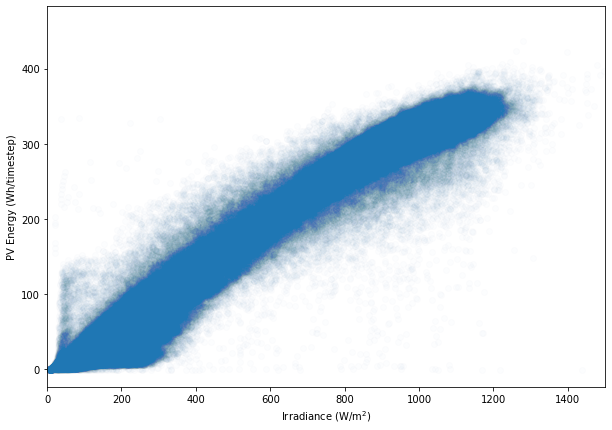

In [9]:
# check that PV energy is roughly proportional to irradiance
# Loops and other features in this plot can indicate things like
# time zone problems for irradiance transposition errors.
fig = sa.plot_pv_vs_irradiance('sensor')

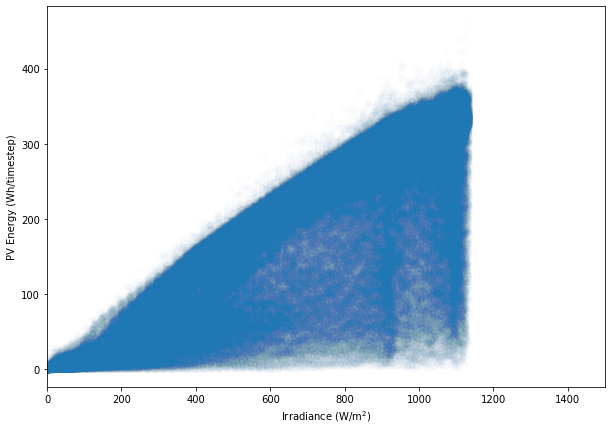

In [10]:
# Repeat the check for clear-sky irradiance
# For this plot, we expect more points below the main point
# cloud due to cloudy conditions.
fig = sa.plot_pv_vs_irradiance('clearsky')

C:\Users\KANDERSO\Software\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


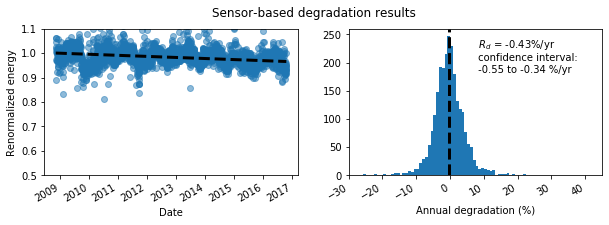

In [11]:
# Plot the sensor-based degradation results
fig = sa.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45)

In [12]:
# Plot the clear-sky-based results
fig = sa.plot_degradation_summary('clearsky', summary_title='Clear-sky-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45, plot_color='orangered')

AttributeError: 'SystemAnalysis' object has no attribute 'results'

The system_analysis class also has built-in methods for plots associated with soiling analysis

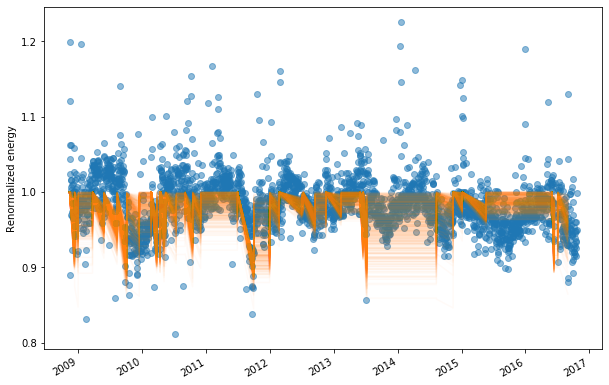

In [13]:
fig = sa.plot_soiling_monte_carlo('sensor', profile_alpha=0.03, profiles=500)

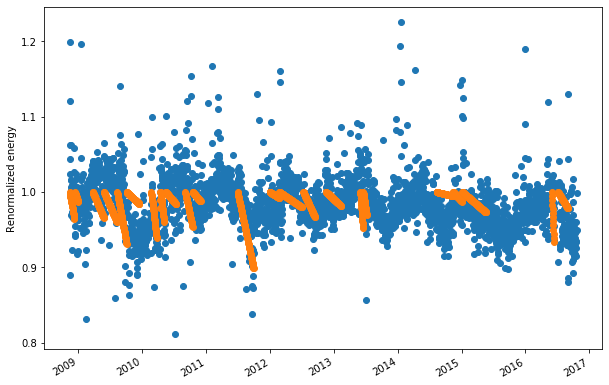

In [14]:
fig = sa.plot_soiling_interval('sensor')

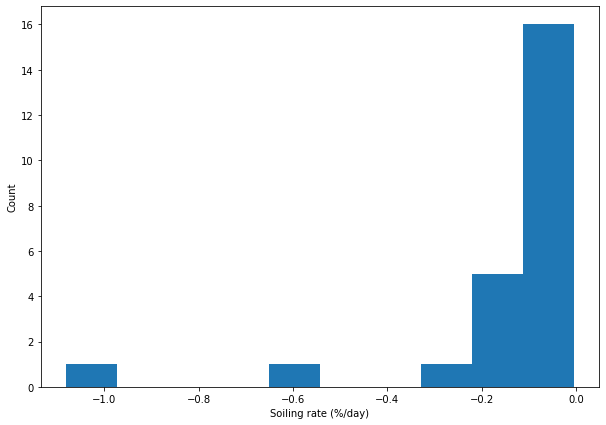

In [15]:
fig = sa.plot_soiling_rate_histogram('sensor')